# Solving Various ODEs

In [ ]:
import requests as req, os

URL = "https://raw.githubusercontent.com/mit-acl/16_06_Class/main/"
File = ["basic_material.py","control_materials.py"]

if not os.path.isfile(File[0]):
    print('Basic files not found - downloading them')
    for dfile in File:
        if not os.path.isfile(dfile):
            print("Downloading "+dfile)
            res = req.get(URL+dfile)
            file = open(dfile, 'w')
            file.write(res.text)
            file.close()

print('Basic file found')
%run basic_material.py

from control.matlab import tf, lsim, step


Basic file found
Running Python: 3.12.8
Running Sympy: 1.13.2
Control Package Found


# Linear System using Control Toolbox

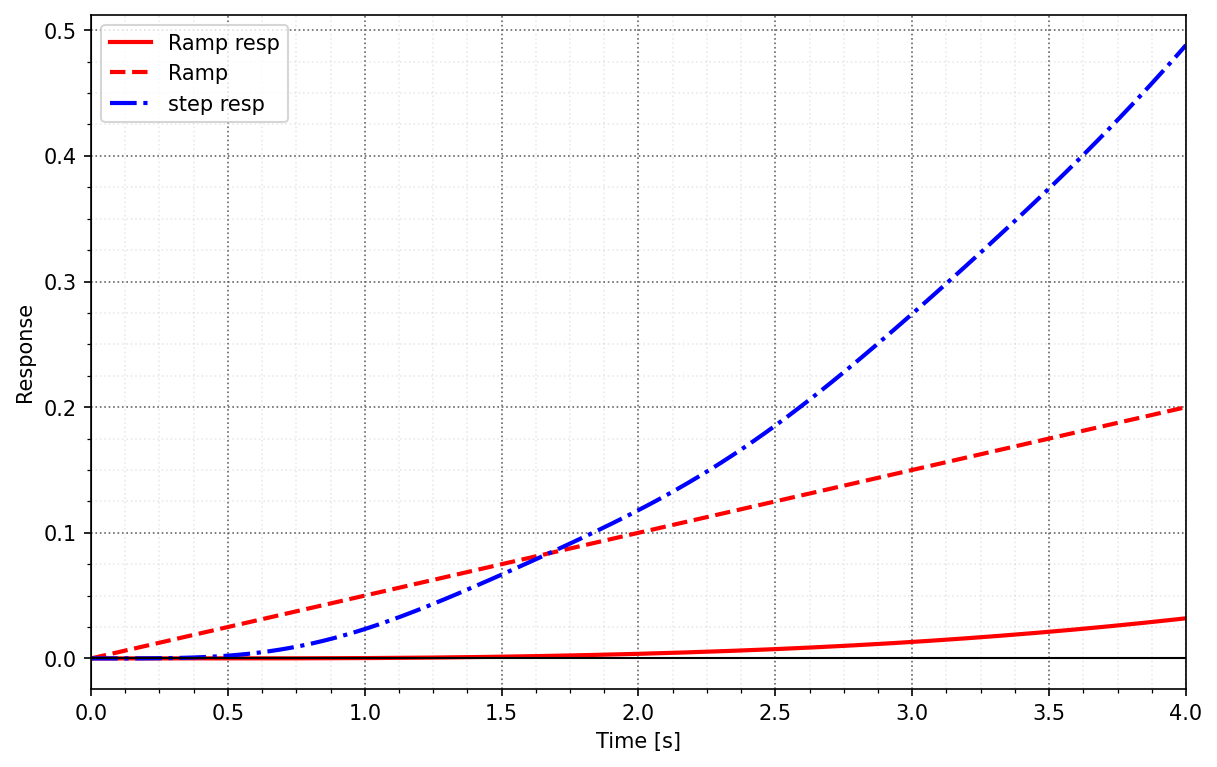

In [ ]:
# Showing step and lsim
t = linspace(0,4,1000)

# create fake system
num = 1
den = np.convolve([1, 0, 0],[1, 2*0.05*4, 4**2])
G = tf(num,den)

# input
ramp = t/20
y_ramp, t_ramp, x_ramp = lsim(G, T=t, U=ramp) # ramp response
y_step, t_step = step(G, T=max(t)) # step response

# plot
fig, ax = plt.subplots(1,figsize=(8, 5),dpi=150,constrained_layout = True)
plt.plot(t_ramp,y_ramp,'r-',label='Ramp resp')
plt.plot(t_ramp,ramp,'r--',label='Ramp')
plt.plot(t_step,y_step,'b-.',label='step resp')
plt.xlabel('Time [s]')
plt.ylabel('Response')
plt.legend()
nicegrid(ax)
plt.show()

# Nonlinear system using Scipy

Simulate cannonball -- vertically we have
$
m \ddot y = - K \dot y^2 -g  
$
and horizontally
$
m \ddot x - K \dot x^2   
$
where $K\dot x^2$ captures the impact of drag

Combine the x,y into 1 state vector $u=[x,y,\dot x, \dot y]^T = [v^T,\dot v^T]$

k: 0.0, Range:  20.39, Height:  -0.00
k: 0.1, Range:  11.68, Height:   0.00
k: 0.1, Range:   8.54, Height:  -0.00
k: 0.2, Range:   6.85, Height:   0.00
k: 0.2, Range:   5.77, Height:   0.00


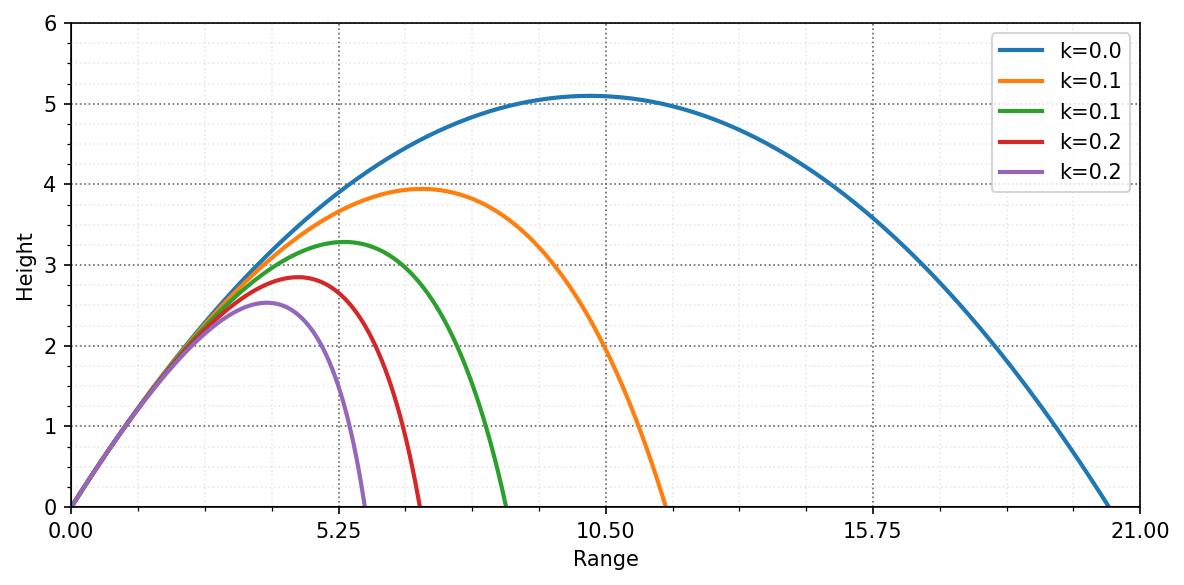

In [ ]:
from scipy.integrate import solve_ivp

m = 1
g = 9.81

# dynamics of a simple mass with ballistic flight and a bit of drag
def cannon(t, v, K): 
    u, udot = v[:2], v[2:]
    udotdot = - K / m * udot**2
    udotdot[1] -= g
    return np.r_[udot, udotdot]

def hit_ground(t, y, k):
    return y[1]

# What stops the sim?
ground_event = lambda t,x:hit_ground(t,x,k)
ground_event.terminal = True
ground_event.direction = -1

y0 = [0, 0, 10, 10] # initial conditions
t_span = [0, 50] # integration time a bit over what is necessary

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
for k in np.linspace(0., .25, 5):
    sol = solve_ivp(fun=lambda t,x:cannon(t,x,k), t_span=t_span, y0=y0, events=ground_event, max_step=0.01)
    ax.plot(sol.y[0,:], sol.y[1,:], '-', mew=2, ms=6, mec='w',label=f'k={k:.1f}')
    print("k: {:0.1f}, Range: {:6.2f}, Height: {:6.2f}".format(*[k, sol.y[0,-1], sol.y[1,-1]]))
ax.set_ylabel("Height")
ax.set_xlabel("Range")
ax.legend()

thalf = y0[3]/g
xmax = np.ceil(y0[2]*2*thalf)
ymax = np.ceil(y0[3]*thalf - 0.5*g*thalf**2)
ax.set_xlim(0, xmax)
ax.set_ylim(0, ymax)
nicegrid(ax,5)
plt.show()

# Using Symbolic Solver

In [ ]:
import sympy as sym
from sympy import symbols, Eq, Function, dsolve
from sympy import exp, plot, sin, cos, printing, init_printing, simplify
t = sym.symbols('t')
y = sym.symbols('y', cls=sym.Function)(t)

In [ ]:
# define a nonlinear set of dynamics that we want to simulate 
# A[0] \ddot y + A[1] \dot y + A[2] y = w

def Solve_ODE0(A = [1,1,1], w = 0, Y0 = [0,0]):
    g0 = symbols('g', cls=sym.Function)
    if len(A) == 3:
        g0 = A[0]*y.diff(t,t) + A[1]*y.diff(t) + A[2]*y - w 
        sol_0 = dsolve(g0, ics={y.subs(t,0): Y0[0], sym.diff(y, t).subs(t,0): Y0[1]})        
    elif len(A) == 2:
        g0 = A[0]*y.diff(t) + A[1]*y - w 
        sol_0 = dsolve(g0, ics={y.subs(t,0): Y0[0]})
    else:
        print("Not sure what problem we are solving")
        return None
    return sym.lambdify([t],sol_0.rhs)

## First Order

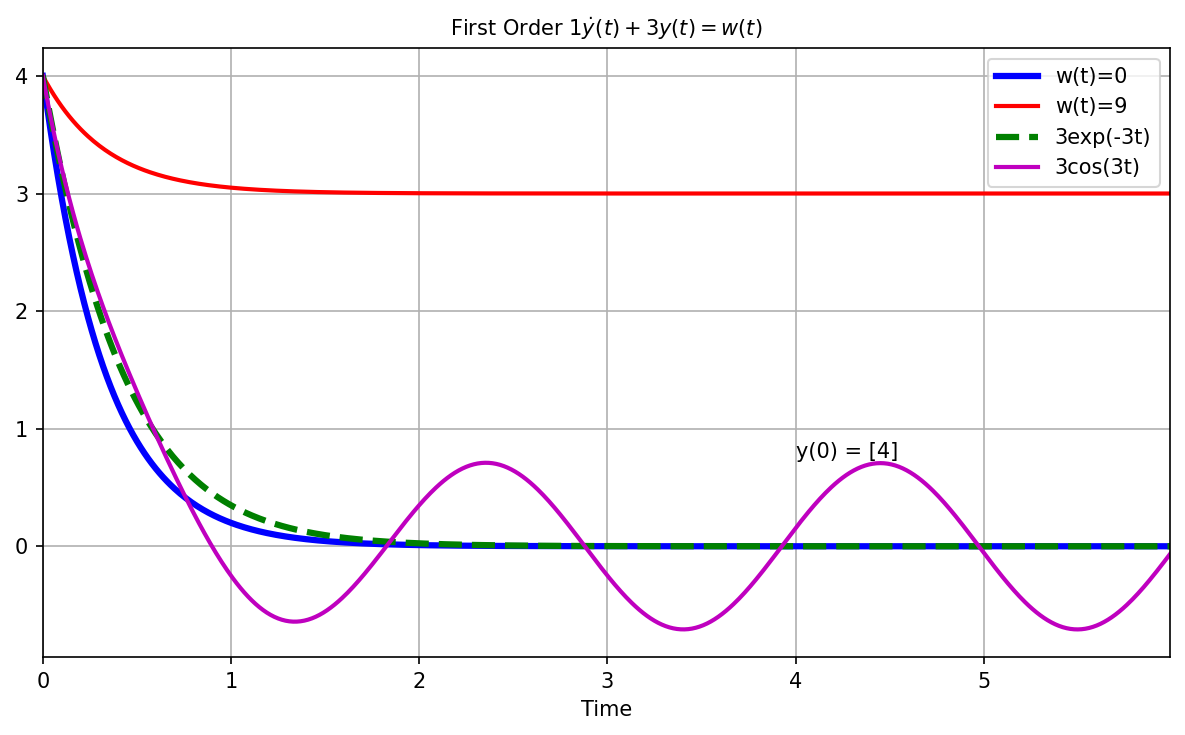

In [ ]:
Y0 = [4]
A = [1, 3]
fun_0 = Solve_ODE0(A=A,w=0,Y0=Y0)
fun_1 = Solve_ODE0(A=A,w=9,Y0=Y0)
fun_2 = Solve_ODE0(A=A,w=3*exp(-3*t),Y0=Y0)
fun_3 = Solve_ODE0(A=A,w=3*cos(3*t),Y0=Y0)

tt = np.arange(0, 6, 0.01)
fig = plt.figure(1,figsize=(8,5))
ax = fig.add_subplot()
ax.plot(tt,fun_0(tt),'b-',label='w(t)=0',lw=3)
ax.plot(tt,fun_1(tt),'r-',label='w(t)=9')
ax.plot(tt,fun_2(tt),'g--',label='3exp(-3t)',lw=3)
ax.plot(tt,fun_3(tt),'m',label='3cos(3t)')
ax.set_xlabel('Time')
ax.text(4,.75,'y(0) = '+str(Y0))
plt.legend()
plt.title('First Order '+str(A[0])+'$\dot y(t) + '+str(A[1])+'y(t) = w(t)$')
savefig('figs/first_order.png', dpi=300)
plt.show()

## Second Order - Complex

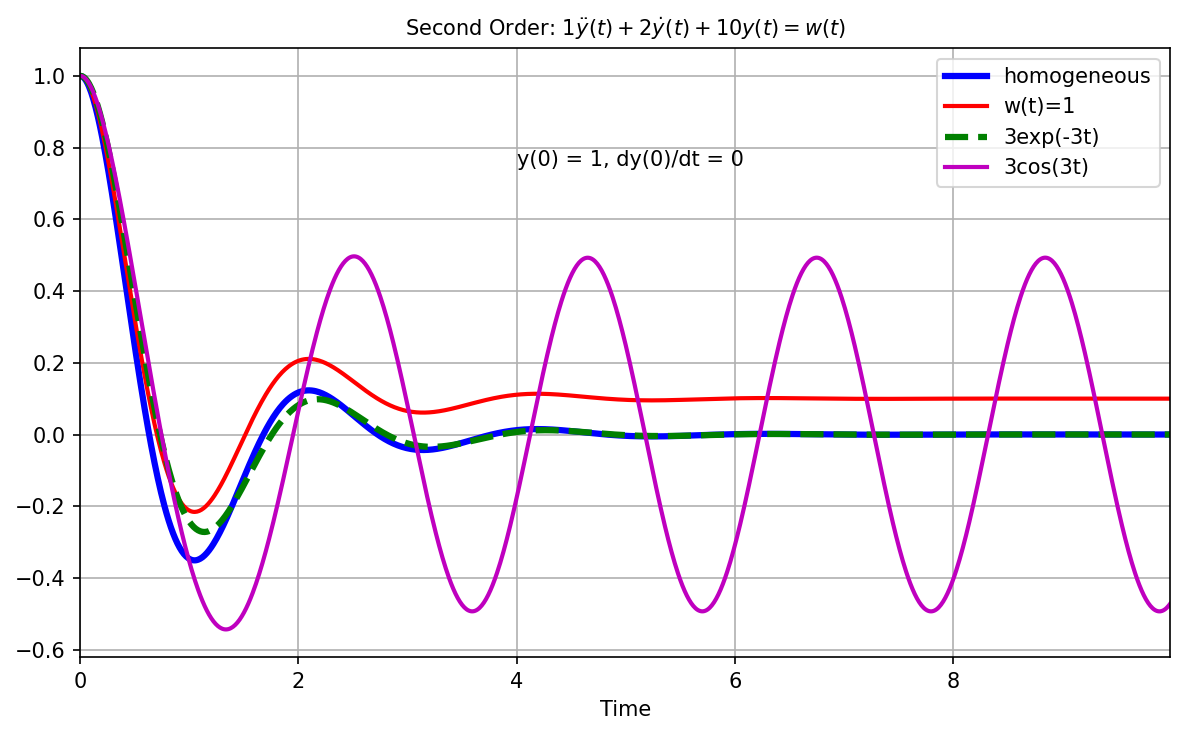

In [ ]:
Y0 = [1, 0]
A = [1, 2, 10]
fun_0 = Solve_ODE0(A=A,w=0,Y0=Y0)
fun_1 = Solve_ODE0(A=A,w=1,Y0=Y0)
fun_2 = Solve_ODE0(A=A,w=3*exp(-3*t),Y0=Y0)
fun_3 = Solve_ODE0(A=A,w=3*cos(3*t),Y0=Y0)

tt = np.arange(0, 10, 0.01)
fig = plt.figure(1,figsize=(8,5))
ax = fig.add_subplot()
ax.plot(tt,fun_0(tt),'b-',label='homogeneous',lw=3)
ax.plot(tt,fun_1(tt),'r-',label='w(t)=1')
ax.plot(tt,fun_2(tt),'g--',label='3exp(-3t)',lw=3)
ax.plot(tt,fun_3(tt),'m',label='3cos(3t)')
ax.text(4,.75,'y(0) = '+str(Y0[0])+', dy(0)/dt = '+str(Y0[1]))
ax.set_xlabel('Time')
plt.legend()
plt.title('Second Order: '+str(A[0])+'$\ddot y(t) + '+str(A[1])+'\dot y(t) + '+str(A[2])+'y(t) = w(t)$')
savefig('figs/second_order_complex.png', dpi=300)
plt.show()

# Using Sympy

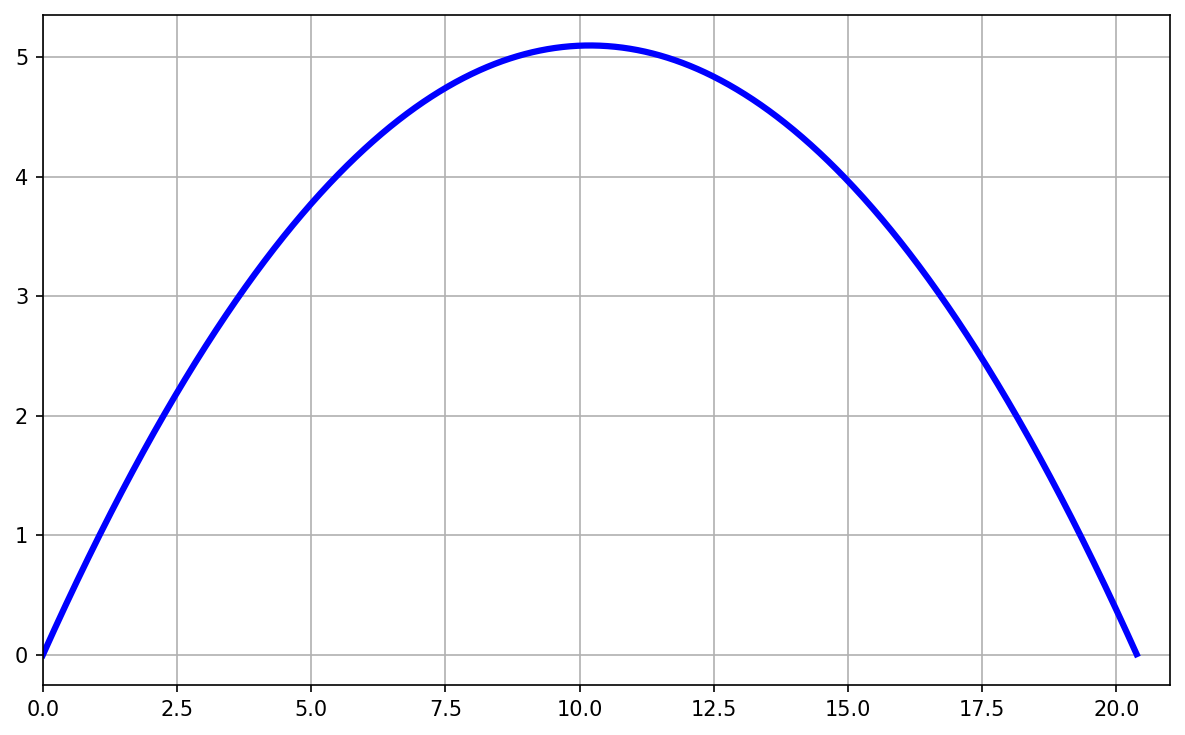

In [ ]:
import sympy as sym
from sympy import symbols, dsolve
t = sym.symbols('t')
y = sym.symbols('y', cls=sym.Function)(t)
x = sym.symbols('x', cls=sym.Function)(t)

Y0 = [0, 0, 10, 10]
m = 1
g = 9.81

def Solve_ODE1(Y0, k=0):
    g0 = symbols('g0', cls=sym.Function)
    g1 = symbols('g1', cls=sym.Function)
    g0 = x.diff(t,t) + k/m*x.diff(t)
    g1 = y.diff(t,t) + k/m*y.diff(t) + g 
    sol_0 = dsolve([g0,g1], ics={x.subs(t,0): Y0[0], sym.diff(x, t).subs(t,0): Y0[2], y.subs(t,0): Y0[1], sym.diff(y, t).subs(t,0): Y0[3]})       
    return sol_0 

fun_0 = Solve_ODE1(Y0=Y0,k=0.0001)
tt = np.arange(0, 5, 0.001)
fig = plt.figure(1,figsize=(8,5))
x = sym.lambdify([t],fun_0[0].rhs)
y = sym.lambdify([t],fun_0[1].rhs)
NN = np.min(np.argwhere(y(tt) < 0))
ax = fig.add_subplot()
ax.plot(x(tt[0:NN]),y(tt[0:NN]),'b-',label='homogeneous',lw=3)
ax.set_xlim(0,21)
plt.show()